# Text Classification with BERT/RoBERTa and Simple Transformers

In [1]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import pandas as pd
import numpy as np
import logging
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
#from pylab import rcParams
import matplotlib.pyplot as plt

In [2]:
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [3]:
model_types = {
    "bert": "cahya/bert-base-indonesian-522M", 
    "roberta":"cahya/roberta-base-indonesian-522M"}
model_name = "bert"

In [4]:
# The dataset can be downloaded from https://github.com/cahya-wirawan/language-modeling/tree/master/data
# and put it under the directory "/dataset/panl"

In [5]:
data = "/dataset/panl"

In [6]:
df_train = pd.read_csv(f'{data}/bppt_panl_train.csv', names=["labels","text"])
df_test = pd.read_csv(f'{data}/bppt_panl_test.csv', names=["labels","text"])
class_names = ['Economy', 'International', 'Science', 'Sport']

In [7]:
# Optional model configuration
model_args = ClassificationArgs()
model_args.num_train_epochs = 3
model_args.train_batch_size = 128
model_args.eval_batch_size = 128
model_args.overwrite_output_dir = True
model_args.fp16 = True
model_args.do_lower_case = True

In [8]:
# Create a ClassificationModel
model = ClassificationModel(
    model_name, model_types[model_name], num_labels=len(class_names), args=model_args
)

In [9]:
df_train.head()

,labels,text
0,1,"Saya berada di sini dua tahun lalu, tapi saat ..."
1,0,Pertumbuhan ekonomi 2007 yang diproyeksikan me...
2,3,Pelatih Real Bernd Schuster harus mengeluarkan...
3,2,Laporan itu adalah pengumuman kedua dari badan...
4,0,"Lonjakan laba bersih tersebut, selain didorong..."


In [10]:
df_test.head()

,labels,text
0,1,Kedua orang yang cedera itu berada dalam kondi...
1,0,"Paradoksnya di sisi lain, sinyal akan diakuiny..."
2,0,"Menurut dia, harga minyak mentah dunia saat in..."
3,2,Pengkajian ini memberikan konfirmasi bahwa kit...
4,3,Gol akhir Marco Borriello membuat Genoa mendap...


In [11]:
# Train the model
model.train_model(df_train)

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.



Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Running loss: 1.432486

/sysadmin/wirawan/miniconda3/envs/transformers/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:113: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Running loss: 0.365464

/sysadmin/wirawan/miniconda3/envs/transformers/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.212048


Running loss: 0.180967


Running loss: 0.147799



INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.


In [12]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(df_test)

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


INFO:simpletransformers.classification.classification_model:{'mcc': 0.9256367880807032, 'eval_loss': 0.17972533953817268}


In [13]:
preds = np.argmax(model_outputs, axis=1)

In [14]:
accuracy = np.sum(df_test['labels']==preds)/len(preds)
accuracy

0.9446525176862256

In [15]:
# Make predictions with the model
predictions, raw_outputs = model.predict(["Indonesia bertanding dalam cabang olahraga bulutangkis di Olimpiade ke 30 di Yunani."])

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


In [16]:
class_names[int(predictions[0])]

'Sport'

In [17]:
print(classification_report(df_test['labels'], preds, target_names=class_names))

               precision    recall  f1-score   support

      Economy       0.96      0.95      0.96       690
International       0.95      0.92      0.94       668
      Science       0.91      0.94      0.93       617
        Sport       0.96      0.97      0.97       428

     accuracy                           0.94      2403
    macro avg       0.95      0.95      0.95      2403
 weighted avg       0.95      0.94      0.94      2403



In [18]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True Topics')
    plt.xlabel('Predicted Topics');


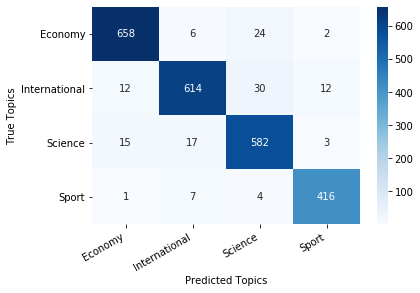

In [19]:
cm = confusion_matrix(df_test['labels'], preds)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)